In [1]:
import sys,glob
sys.path.append("../")
from Reconstruction.models.simpleAE import simpleAE
from Reconstruction.models.LinearVAE import LinearVAE
from torchvision.datasets import MNIST
import torch
import torchvision.transforms as transforms
import os, pickle, cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.manifold import TSNE

In [25]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=MNIST('../Reconstruction/data/{0}'.format("mnist"), train=True,download=True ,transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor()])), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=MNIST('../Reconstruction/data/{0}'.format("mnist"), train=False,download=True, transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor()])), batch_size=batch_size, shuffle=True)


Processing...
Done!


In [12]:
checkpoints = glob.glob(pathname='../Reconstruction/minst_checkpoints/{0}*'.format("LinearVAE"))
checkpoints

['../Reconstruction/minst_checkpoints/LinearVAE_16.pth',
 '../Reconstruction/minst_checkpoints/LinearVAE_64.pth',
 '../Reconstruction/minst_checkpoints/LinearVAE_128.pth',
 '../Reconstruction/minst_checkpoints/LinearVAE_32.pth']

16
64
32
16


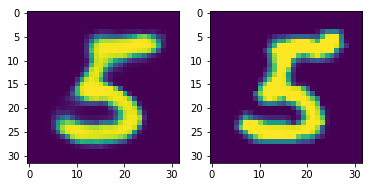

64


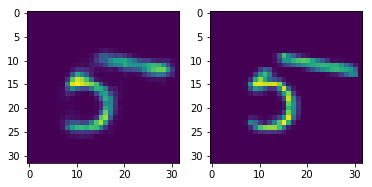

32


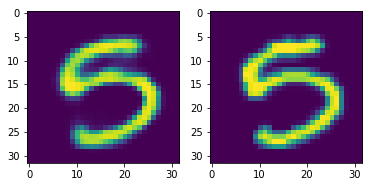

In [37]:
models = []
dims = [16, 64, 32]
for i in dims:
    print(i)
    model = LinearVAE(z_dim=i, hidden=512, num_channels=32*32)
    model.load(path='../Reconstruction/minst_checkpoints/LinearVAE_{}.pth'.format(i))
    models.append(model)
    
for i,model in zip(dims,models):
    print(i)
    eg, _ = next(iter(train_loader))
    mu, sigma = model.encoder(eg.view(eg.shape[0], 1, -1))
    epsilon = torch.autograd.Variable(torch.randn(mu.size()), requires_grad=False).type(torch.FloatTensor)
    sigma = torch.exp(sigma / 2)
    z = (mu + sigma * epsilon).detach().numpy()[0, 0, :]

    output = model.decoder(torch.from_numpy(z).float()).detach().numpy().reshape(32, 32)
    plt.subplot(121)
    plt.imshow(output)
    plt.subplot(122)
    plt.imshow(eg[0, 0, :, :].numpy())
    plt.show()

## generate 

In [44]:
model = models[2]

In [45]:

count = 0
data_collected = []
imgs = []
labels = []
for bch,lab in train_loader:
    count +=1 
    if(count >= 200):
        break
    mu, sigma = model.encoder(eg.view(eg.shape[0], 1, -1))
    mu = mu.detach().numpy()
    data_collected.append(mu.reshape((bch.shape[0],-1)))
    labels.append(lab)
    imgs.append(bch.reshape((bch.shape[0],32,32)))
    
data_collected = np.concatenate(data_collected,axis = 0)
labels = np.concatenate(labels,axis = 0)
imgs = np.concatenate(imgs,axis = 0)
print(data_collected.shape,labels.shape,imgs.shape)

(6368, 32) (6368,) (6368, 32, 32)


In [46]:
data_embedded = TSNE(n_components=2).fit_transform(data_collected)
data_embedded.shape
print(np.max(data_embedded,axis = 0),np.min(data_embedded,axis = 0))

[45.41677 59.68373] [-57.825417 -52.286762]


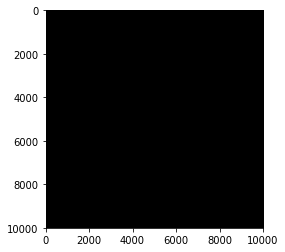

In [47]:
TotalSize = 10000
EmbedMax = 1#40
fig = np.zeros((TotalSize,TotalSize))
for i,img in enumerate(imgs):
    x = data_collected[i][0]
    y = data_collected[i][1]
#     print(img.shape)
    
    xx = int((x+EmbedMax)*TotalSize/EmbedMax)
    yy = int((y+EmbedMax)*TotalSize/EmbedMax)
#     print(xx,yy)
    tmp = fig[xx:xx+img.shape[0],yy:yy+img.shape[1]]
    if(tmp.shape[0]<28 or tmp.shape[1]<28):
        continue
#     print(tmp.shape)
    tmp = np.concatenate([tmp.reshape(1,*(tmp.shape)),img.reshape((1,*(img.shape)))],axis = 0)
    tmp = np.max(tmp,axis = 0)
    fig[xx:xx+img.shape[0],yy:yy+img.shape[1]] = tmp

plt.imshow(fig,"gray")
plt.imsave("embed.png",fig)
plt.show()


# 可以看出这个聚类聚得十分的分散！上图每一个点都是好多个数字的重叠

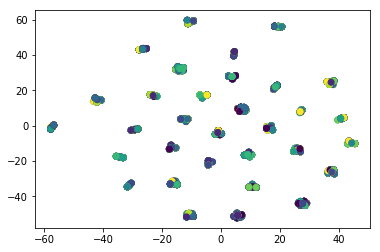

In [48]:
fig = plt.figure()
plt.scatter(data_embedded[:,0],data_embedded[:,1],c=labels)
fig.figimage(imgs[0], 0, fig.bbox.ymax - 0)
plt.show()

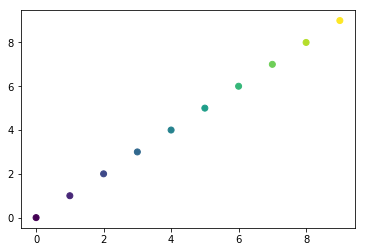

In [19]:
plt.scatter(np.arange(10),np.arange(10),c=np.arange(10))
plt.show()